In [1]:
import time
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.extmath import randomized_svd

In [2]:
def svd(X, k=None):
    if k is None:
        k = min(*X.shape)
    U, s, Vh = np.linalg.svd(X, full_matrices=False)
    return U[:, :k] * s[:k] @ Vh[:k]

def rsvd(X, k=None, n_oversamples=10, n_iter='auto', random_state=None):
    # https://scikit-learn.org/dev/modules/generated/sklearn.utils.extmath.randomized_svd.html
    # https://scikit-learn.org/dev/modules/generated/sklearn.decomposition.TruncatedSVD.html
    if k is None:
        k = min(*X.shape)
    U, s, Vh = randomized_svd(
        X, 
        k, 
        random_state=random_state, 
        n_oversamples=n_oversamples, 
        n_iter=n_iter
    ) # last two params speed-accuracy tradeoff
    return U * s @ Vh

In [3]:
def rank_experiment(X, func, ranks, n_trials: int = 5):
    to = []
    eo = []
    
    for k in tqdm.tqdm(ranks):
        ti = []
        ei = []
        
        for trial in range(n_trials):
            t0 = time.perf_counter()
            er = np.linalg.norm(X - func(X, k))
            t1 = time.perf_counter()

            ti.append(t1 - t0)
            ei.append(er)
        
        to.append(ti)
        eo.append(ei)

    to = np.array(to)
    eo = np.array(eo)
    
    metrics = {}
    metrics["rank"] = ranks
    metrics["time_avg"] = to.mean(axis=1)
    metrics["time_std"] = to.var(axis=1)
    metrics["error_avg"] = eo.mean(axis=1)
    metrics["error_std"] = eo.var(axis=1)
    
    return metrics

## Experiment 1: Low-rank approximation of a fixed matrix

In [4]:
%%time

# Run experiment over many ranks
np.random.seed(42)

ranks = np.linspace(100, 1000, num=10, dtype=int) # NOTE: This is small for testing purposes, real deal should be at least 2 order magnitude greater
n = ranks[-1]
X = np.random.normal(0, 1, (n, n))
n_trials = 10
print("Matrix:", X.shape, "ranks:", ranks, "n_trials:", n_trials)

measures = ["time", "error"]
methods = []

# Exact
f = svd
metrics = {}
metrics["name"] = [f.__name__] * len(ranks)
func = lambda x, k: svd(x, k)
metrics = {**metrics, **rank_experiment(X, func, ranks, n_trials)}
methods.append(metrics)

# Approximate
f = rsvd
metrics = {}
metrics["name"] = [f.__name__ + " (n_oversamples=0,n_iter=0)"] * len(ranks)
func = lambda x, k: f(x, k, n_oversamples=0, n_iter=0)
metrics = {**metrics, **rank_experiment(X, func, ranks, n_trials)}
methods.append(metrics)

f = rsvd
metrics = {}
metrics["name"] = [f.__name__ + " (n_oversamples=10,n_iter=0)"] * len(ranks)
func = lambda x, k: f(x, k, n_oversamples=10, n_iter=0)
metrics = {**metrics, **rank_experiment(X, func, ranks, n_trials)}
methods.append(metrics)

f = rsvd
metrics = {}
metrics["name"] = [f.__name__ + " (n_oversamples=0,n_iter=1)"] * len(ranks)
func = lambda x, k: f(x, k, n_oversamples=0, n_iter=1)
metrics = {**metrics, **rank_experiment(X, func, ranks, n_trials)}
methods.append(metrics)

Matrix: (1000, 1000) ranks: [ 100  200  300  400  500  600  700  800  900 1000] n_trials: 10


100%|██████████| 10/10 [00:14<00:00,  1.42s/it]

CPU times: user 1min 15s, sys: 13.3 s, total: 1min 28s
Wall time: 59.5 s


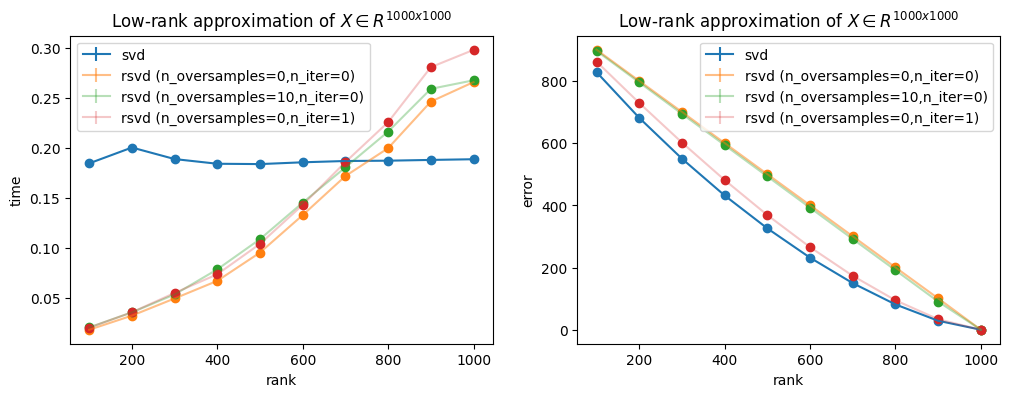

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for i, measure in enumerate(measures):
    for j, metrics in enumerate(methods):
        ax[i].errorbar(ranks, metrics[f"{measure}_avg"], metrics[f"{measure}_std"], label=metrics["name"][0], alpha=1/(j+1))
        ax[i].scatter(ranks, metrics[f"{measure}_avg"])

    ax[i].set_title(f"Low-rank approximation of $X \\in R^{{{n}x{n}}}$")
    ax[i].set_xlabel("rank")
    ax[i].set_ylabel(measure)
    ax[i].legend()
    
plt.show()

In [6]:
df = pd.DataFrame(methods)
df = df.explode(df.columns.tolist())
df

,name,rank,time_avg,time_std,error_avg,error_std
0,svd,100,0.18453,0.000036,828.336423,0.0
0,svd,200,0.200342,0.000027,681.318158,0.0
0,svd,300,0.1888,0.000053,550.10497,0.0
0,svd,400,0.184118,0.000001,431.755695,0.0
0,svd,500,0.18379,0.000004,325.941131,0.0
0,svd,600,0.18558,0.0,231.696034,0.0
0,svd,700,0.186873,0.000001,149.789119,0.0
0,svd,800,0.187184,0.000001,81.375658,0.0
0,svd,900,0.187947,0.000001,28.824422,0.0
0,svd,1000,0.188644,0.000001,0.0,0.0


## Experiment 2: Low-rank approximation of different matrix scales

In [7]:
# Run experiment over many sizes
np.random.seed(42)

# Xs = [
#     np.random.normal(0, 1, (n, n)),
#     np.random.normal(0, 1, (n, n)),
#     ...
#     np.random.normal(0, 1, (n, n)),
# ]

## Experiment 3: rSVD Hyperparameters

In [8]:
# Experiments demonstrating impact of parameters on runtime and accuracy (which depend on properties of data)
# Requires reviewing https://arxiv.org/abs/0909.4061
# above is theoretical justification
# and https://github.com/scikit-learn/scikit-learn/blob/6bf2061f7/sklearn/utils/extmath.py#L524C3-L530C6
# above is basically the meat of the implementation